In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace, mass
from skfem.helpers import grad, dot, laplacian

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

In [50]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True)
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p):

    plt.figure(figsize=(8,6))
    scatter_ux = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_x, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_ux, label='$\\Delta u_x$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_x$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de u_y
    plt.figure(figsize=(8,6))
    scatter_uy = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_y, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_uy, label='$\\Delta u_y$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_y$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de la presión
    plt.figure(figsize=(8,6))
    scatter_p = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_p, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_p, label='$\\Delta p$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta p$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

In [68]:
# Definir dominio y mallado
nx, ny = 10, 10
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

In [69]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N = Nu + Np

In [70]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M =  asm(mass_matrix, basis_u)    

# Construcción del ssitema
K = bmat([[A,    B.T],
          [B,    None]], format='csr')  # 'None' aquí sí se infiere porque están B y B^T

zeros = sp.csr_matrix((basis_p.N, basis_p.N))  # (Np x Np) cero
L = bmat([[M,   None],
          [None, zeros]], format='csr')


In [71]:
# Shift-invert mode
sigma = 0.0  

# Construir K_shifted = K - sigma * L
K_shifted = K - sigma * L

# Construir matriz del nuevo problema
K_inv = np.linalg.inv(K_shifted.toarray()) 
op    = K_inv @ L


In [72]:
# Version usando factorización LU (más eficiente para grandes sistemas)
# lu = splu(K_shifted.tocsc())

# # Definir operador lineal: (K - sigma*L)^(-1) * L
# def matvec(v):
#     #Aplicar (K - sigma*L)^(-1) * L * v
#     Lv = L.dot(v)
#     return lu.solve(Lv)


# Crear LinearOperator
# n_total = K.shape[0]
# op = LinearOperator((n_total, n_total), matvec=matvec, dtype=np.float64)

In [75]:
# Resolver el problema de valores propios
k_eigs = 50
eigenvalues_inv, eigenvectors = eigs(op, k=k_eigs, which='LM', 
                                      tol=1e-6, maxiter=1000)

In [76]:
# Transformar de vuelta a autovalores originales
# lambda = sigma + 1/mu
eigenvalues = sigma + 1.0 / eigenvalues_inv

# Ordenar por magnitud
idx = np.argsort(np.abs(eigenvalues))
# Seleccionar solo los autovalores y autovectores reales (parte imaginaria cero)
mask_real = np.isclose(eigenvalues.imag, 0)
eigenvalues = eigenvalues[idx][mask_real].real
eigenvectors = eigenvectors[:, idx][:, mask_real].real

In [77]:
eigenvectors

array([[-2.30462642e-02, -3.16816411e-02, -6.59932219e-02, ...,
        -9.25158691e-03,  3.15896534e-02,  1.38800466e-02],
       [ 4.16706540e-02, -3.55506303e-02, -6.23818749e-03, ...,
         2.62563841e-02, -4.43738620e-02,  9.93500025e-03],
       [-2.30462642e-02, -3.16816411e-02, -6.25180252e-02, ...,
        -8.92326423e-03, -5.94338350e-03,  3.18196053e-02],
       ...,
       [ 1.02551434e-15,  3.70055932e-16,  1.82929168e-04, ...,
         9.65103990e-03, -3.55698547e-02, -7.28040894e-02],
       [ 5.36094702e-16,  3.83348933e-16, -8.91711809e-05, ...,
        -9.29826726e-03, -1.16316084e-02, -1.31873206e-01],
       [-9.89048758e-18, -4.55609885e-16, -1.18802963e-04, ...,
         1.00581161e-02, -2.59174230e-03, -9.49105395e-04]],
      shape=(1003, 29))

In [78]:
eigenvalues

array([ 6.66133815e-14,  6.66133815e-14,  9.86436837e+00,  9.98930930e+00,
        1.19003748e+01,  2.53518036e+01,  2.61587858e+01,  3.92218854e+01,
        3.99324209e+01,  4.59395755e+01,  5.34430827e+01,  5.73011287e+01,
        7.89362802e+01, -8.01591047e+01,  8.37642161e+01,  8.77072758e+01,
        8.91365437e+01,  1.03137083e+02,  1.12515707e+02,  1.34938286e+02,
        1.39238585e+02,  1.57226666e+02,  1.62623992e+02, -1.67904542e+02,
        1.72225389e+02,  1.90837390e+02,  2.14326837e+02,  2.33706195e+02,
        2.58812476e+02])

In [84]:
# Extraer autofunciones
i = 1
mode_i = eigenvectors[:, i]

u_vector = mode_i[:Nu].real    # Primeros Nu elementos = velocidad
p_vector = mode_i[Nu:].real    # Últimos Np elementos = presión

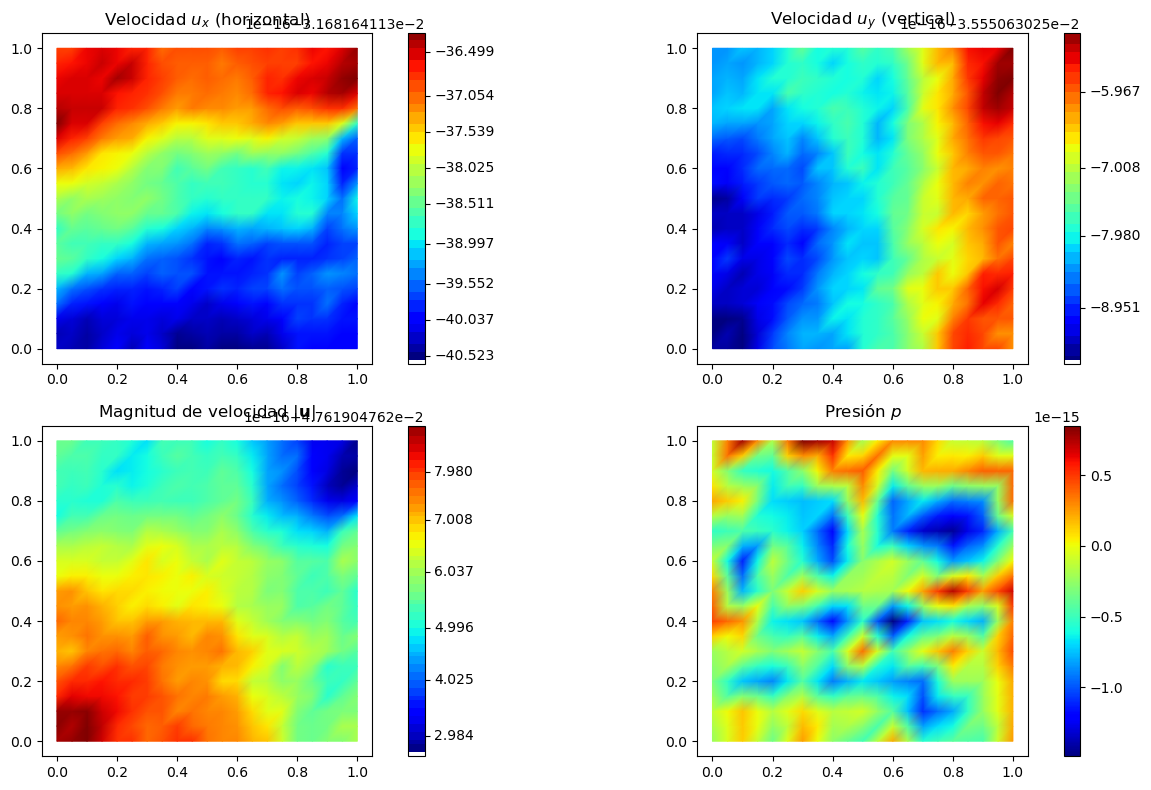

In [85]:
graficar_stokes(u_vector, p_vector, mesh, basis_p, basis_u)